# Advanced Lane Lines Project

This is an improvement for project #1 where we just maked the lane lines, but without caring for the radius or the relative position of the car.

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle
position.

### Camera Calibration
1. Have the camera matrix and distortion coefficients been computed correctly and
checked on one of the calibration images as a test?

In [1]:
## Get all the needed imports
import pickle
import matplotlib.pyplot as plt
import cv2
from glob import glob
import matplotlib.image as mpimage
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
# all the pyploy images print them in this page
%matplotlib inline

## Generic fuction to show an array of images
def plot_imgArr(img_arr, label=None, predict=None, gray=False, n=2):
    """
    :img_arr: An iterable list of images
    :label: The title of the image
    :gray: True if the image is to be shown in black and white
    :n: The number of 2 image rows.
    """
    f, arr = plt.subplots(n,2, figsize=(20,10))

    for n, subplt in enumerate(arr.reshape(-1)):
        if gray:
            subplt.imshow(img_arr[n],  cmap='gray')
        else:
            subplt.imshow(img_arr[n])
        subplt.axis('off')
        if label is not None and predict is None:
            subplt.set_title("st: "+str(label[n]))
        elif label is not None and predict is not None:
            subplt.set_title("st:"+str(label[n]) + "p:"+str(predict[n]))
    plt.show()


Verify current location:

In [ ]:
%pwd

Get the points to calibrate the camera:

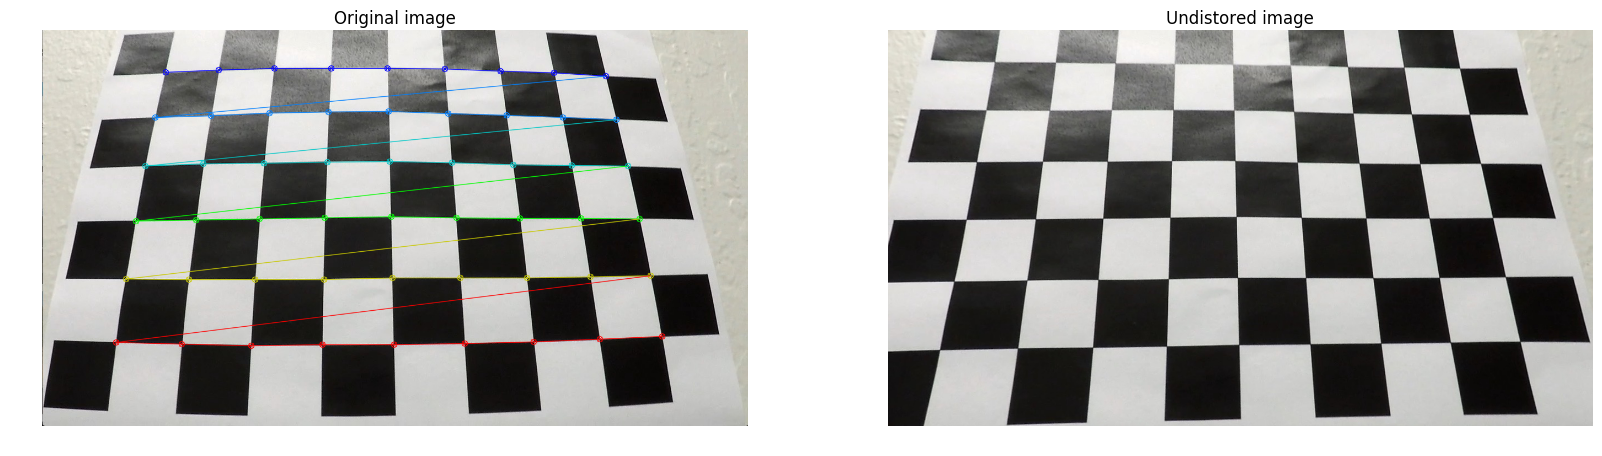

In [2]:
# get all the images from the camera_cal folder
# from: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
"""
Parameters and constats
"""
# Number of corners in x
nx = 9
# Number of corners in y
ny = 6
# Pickle file path 
CAMERA_UNDISTORT_FILE = "/home/porko/workspace/nd_selfDrive/CarND-Advanced-Lane-Lines/output_images/calibration/"
# Pickle file name
CAMERA_PICKLE_NAME = "camera_undist.p"
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
imgs = glob("camera_cal/calibration*")

img_list = [None] * len(imgs)
for i, path_img in enumerate(imgs):
    img = plt.imread(path_img)
    g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(g_img, (nx,ny))
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, True)
        img_list[i] = img.copy()


# This function returns the camera matrix (mtx), distortion coefficients and rotation and translation vectors
h,w = img_list[0].shape[:2]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (h,w),None,None)
# refine the matrix with the open cv function
## Why not user getOptimalNewCameraMatrix?
#newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
#x,y,w,h = roi
img_list_und =[None] * len(imgs)

for n, path_img in enumerate(imgs):
    img = plt.imread(path_img)
    # in case we want to use getOptimalNewCameraMatrix change the second mtx for newcameramtx
    dst = cv2.undistort(img, mtx, dist, None, mtx) 
    # 
    img_list_und[n] = dst
    cv2.imwrite('./output_images/calibration/calibresult_'+str(n)+'.jpg',dst)
    
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.set_title("Original image")
ax1.axis('off')
ax1.imshow(img_list[12])

ax2.set_title("Undistored image")
ax2.axis('off')
ax2.imshow(img_list_und[12])


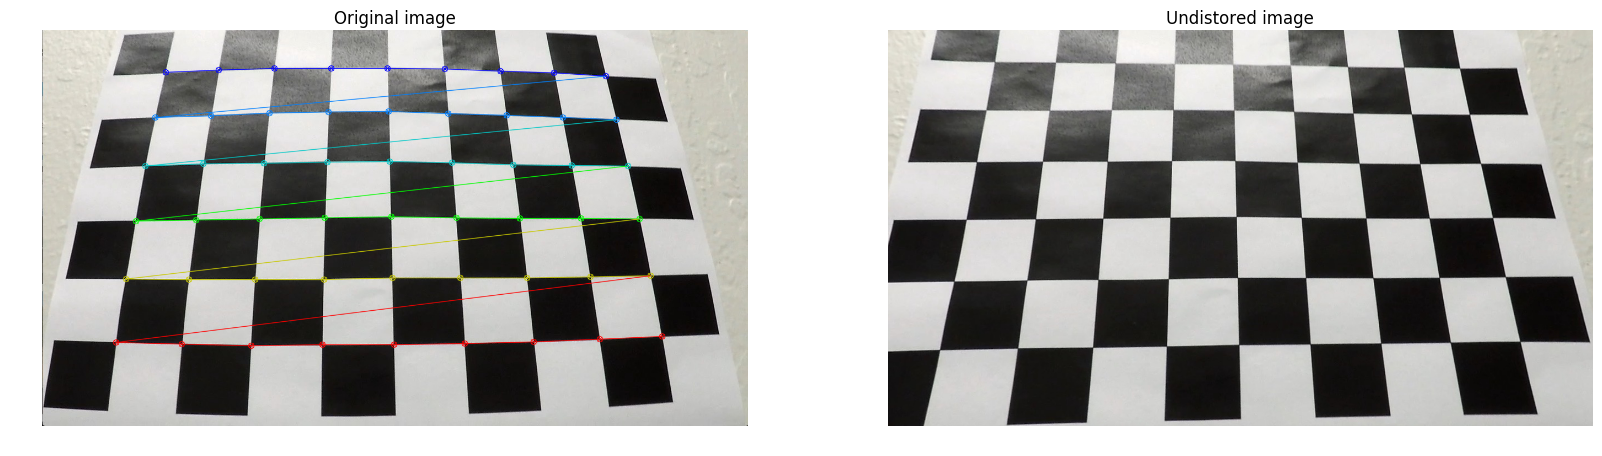

In [3]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.set_title("Original image")
ax1.axis('off')
ax1.imshow(img_list[12])

ax2.set_title("Undistored image")
ax2.axis('off')
ax2.imshow(img_list_und[12])

Once we are satisfied with the coefficients, save them into a pickle file.

In [4]:
camera_undist = {"mtx": mtx, "dist":dist, "rvecs":rvecs, "tvecs":tvecs}
pickle.dump(camera_undist, open(CAMERA_UNDISTORT_FILE+CAMERA_PICKLE_NAME, "wb"))

### Pipeline (single images)

#### Distortion correction.
Has the distortion correction been correctly applied to each image?

In [5]:
# With the generated matrix apply the undistort operation for the test images

def car_undistort(img):
    try: mtx
        # chek if the camera_undist is available
    except:
        camera_undist = pickle.load(open(CAMERA_UNDISTORT_FILE+CAMERA_PICKLE_NAME, "rb"))
        mtx = camera_undist["mtx"]
        dist = camera_undist["dist"]
        rvecs = camera_undist["rvecs"]
        tvecs = camera_undist["tvecs"]
    finally:
        return cv2.undistort(img, mtx, dist, None, mtx)

Undistor test images:

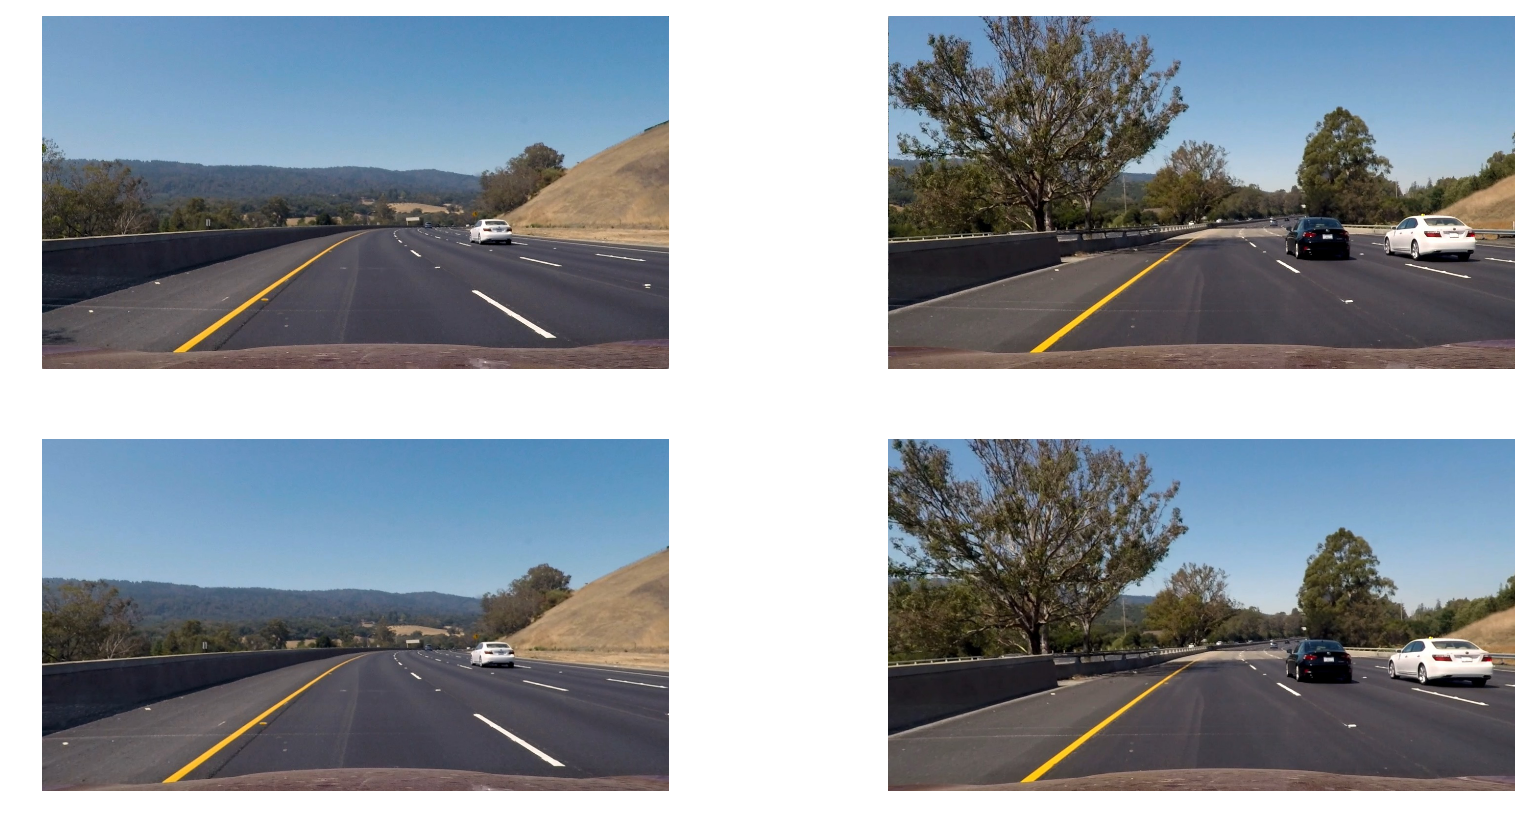

In [6]:
test_images = glob("./test_images/test*.jpg")

orig_img = [None] * len(test_images)
undist_img = [None] * len(test_images)
for n,test_img in enumerate(test_images):
    img = plt.imread(test_img)
    orig_img[n] = img
    undist_img[n] = car_undistort(img)

plot_imgArr([*orig_img[:2],*undist_img[:2] ])


#### Color transformation and gradients
Has a binary image been created using color transforms, gradients or other methods?

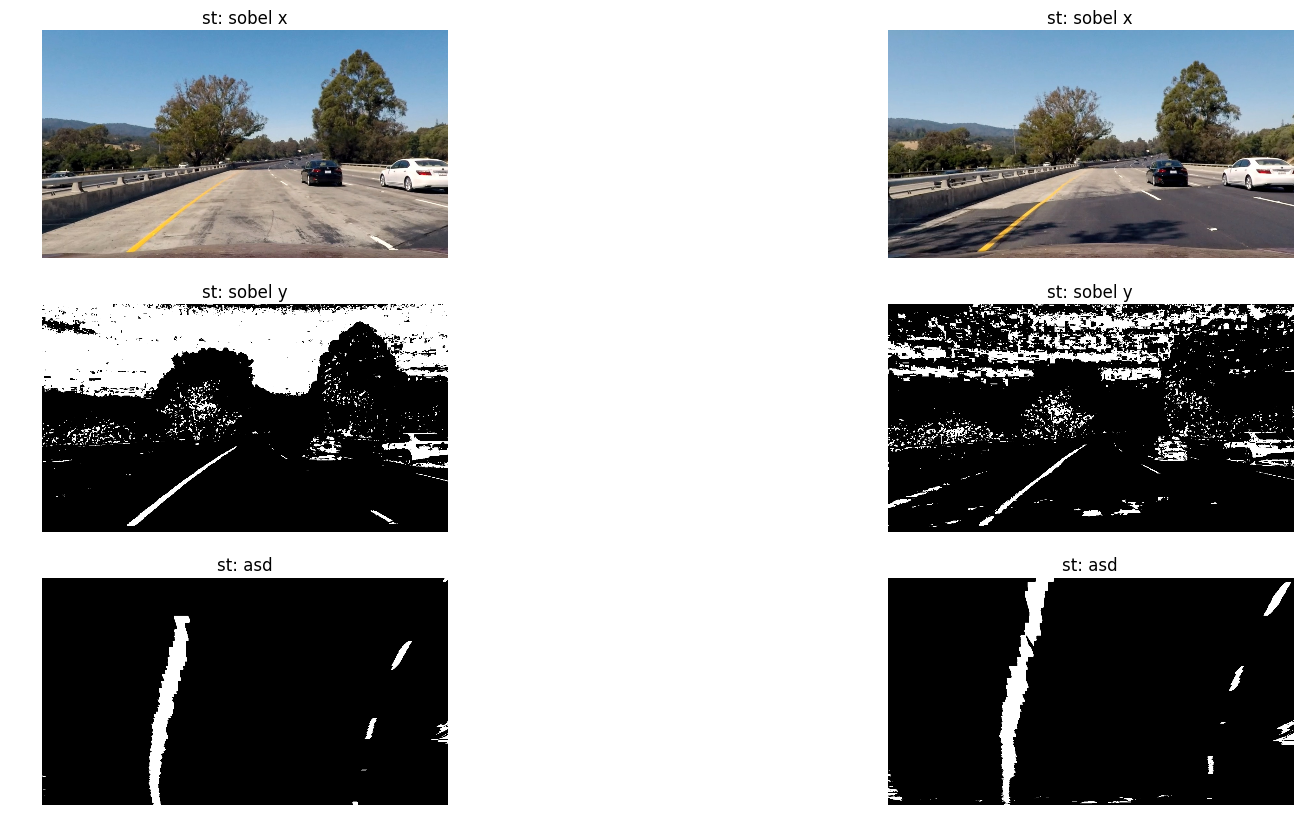

In [9]:
# With the undistored images Check which combinations of color-space and
# gradients give a better lane detection
def car_sobel(gray_img, dir='x', k_size=3):
    if dir == 'x':
        sobel_img = np.abs(cv2.Sobel(gray_img,cv2.CV_64F, 1,0, ksize=k_size))
    else:
        sobel_img = np.abs(cv2.Sobel(gray_img,cv2.CV_64F, 0,1, ksize=k_size))
    scaled =sobel_img# np.uint8(255*sobel_img/np.max(sobel_img))
    return scaled
    
def bw_threshold(img, lim=(127,255)):
    """
    Takes a B/W 8 bit image and applies the threshold operation
    """
    
#    if img.shape[2] != 1:
    #img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

    th_img = np.zeros_like(img)
    th_img[(img > lim[0])&(img <= lim[1])] = 1
    return th_img 

def th_image(img):
    img_g = np.uint8(cv2.cvtColor(img, cv2.COLOR_BGR2HLS))
    s_img = img_g[:,:,2]
    th_img = np.zeros_like(s_img)
    th_img[(s_img > 120)&(s_img<=255)] = 1
    #sbl_img = np.abs(cv2.Sobel(th_img, cv2.CV_64F, 1,0))
    return th_img

def car_laplacian(img):
    return cv2.Laplacian(img,cv2.CV_64F)

def birds_eye_transform(img_src):
    # from the center of the image
    img = img_src.copy()
    if len(img.shape) == 2:
        h,w = img.shape
    elif len(img.shape) == 3:
        h,w = img.shape[:2]
        
    pts = np.array([[w*0.19, h*.95], [(w*0.47), h*0.62], [w*0.53, h*0.62], [w*0.83, h*.95]], np.int32)
    pts_rs = pts.reshape((-1,1,2))
    #img = cv2.polylines(img,[pts_rs],True,(0,255,255))
    dst_pts =np.array([[(w / 4), 0],[(w / 4), h],[(w * 3 / 4), h],[(w * 3 / 4), 0]], dtype='float32')
#    dst_pts =np.array([[320, 0],[320, 720],[970, 720],[960, 0]], dtype='float32')
    pts = np.float32(pts)
    mtx_bv = cv2.getPerspectiveTransform(pts, dst_pts)
    bird_img = cv2.warpPerspective(img, mtx_bv, (w,h) )
    bird_img = bird_img[::-1]
    #plt.savefig('birds_view.png',bird_img)
    return bird_img
def tst(img):
    return birds_eye_transform(th_image(img)) 

# apply sobel for the default X direction    
#bw_imgs_x = [car_sobel(bw_threshold(im, (200,255)))[:,:,1] for im in undist_img]
#bw_imgs_x = [birds_eye_transform(th_image(im)) for im in undist_img]
#bw_imgs_x = [th_image(birds_eye_transform(im)) for im in undist_img]
bw_imgs_x = [birds_eye_transform(th_image(im)) for im in undist_img]


# apply sobel for the Y direction
sobel_imgs_y = [th_image(im) for im in undist_img]
title = ['sobel x','sobel x',  'sobel y','sobel y', 'asd', 'asd']
#plot_imgArr([*bw_imgs_x[0:2], *sobel_imgs_y[0:2]], label=title, n=2, gray=True)
plot_imgArr([*undist_img[2:4],*sobel_imgs_y[2:4], *bw_imgs_x[2:4] ], label=title, n=3, gray=True)

Has a perspective transform been applied to rectify the image?

Select a group of points to represent the perspective transform.

Have lane line pixels been identified in the rectified image and fit with a polynomial?

Fit the points in a polynomial.

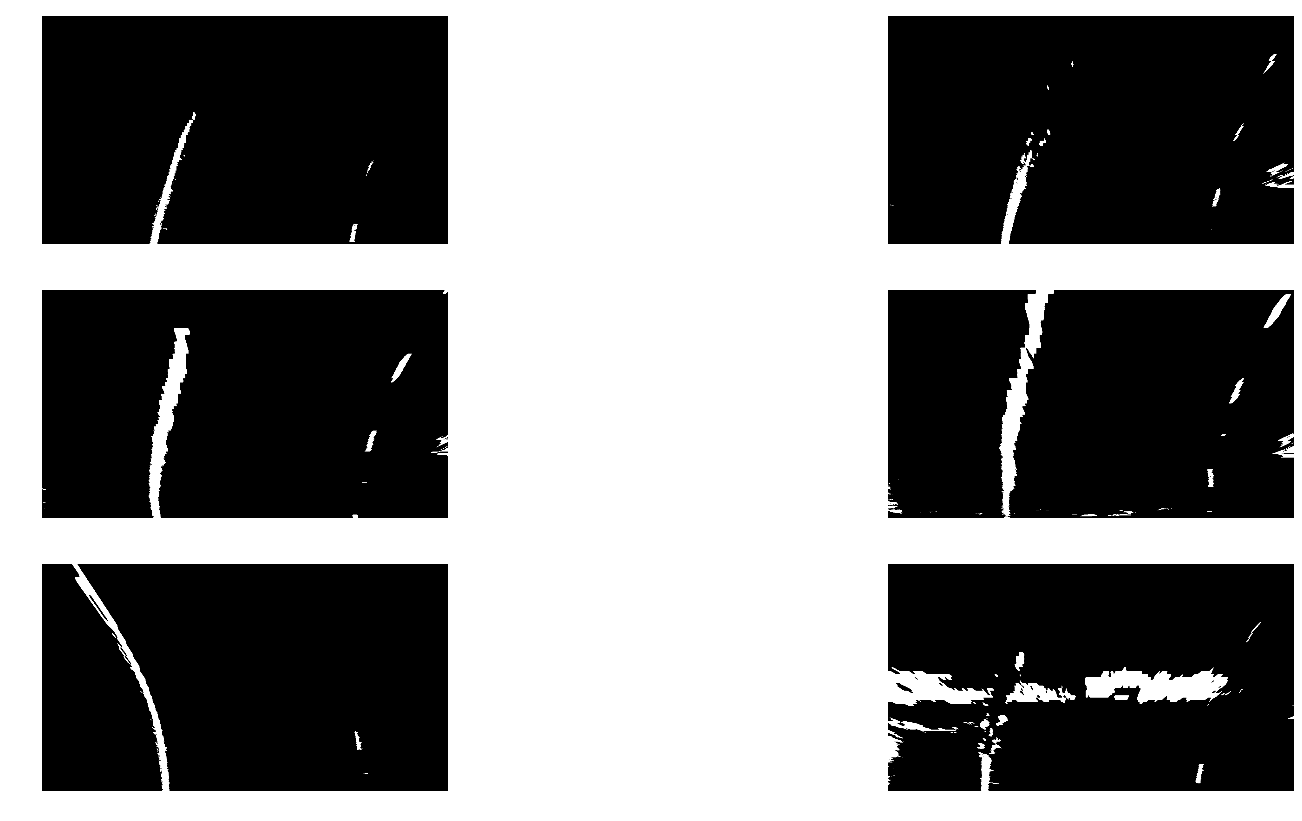

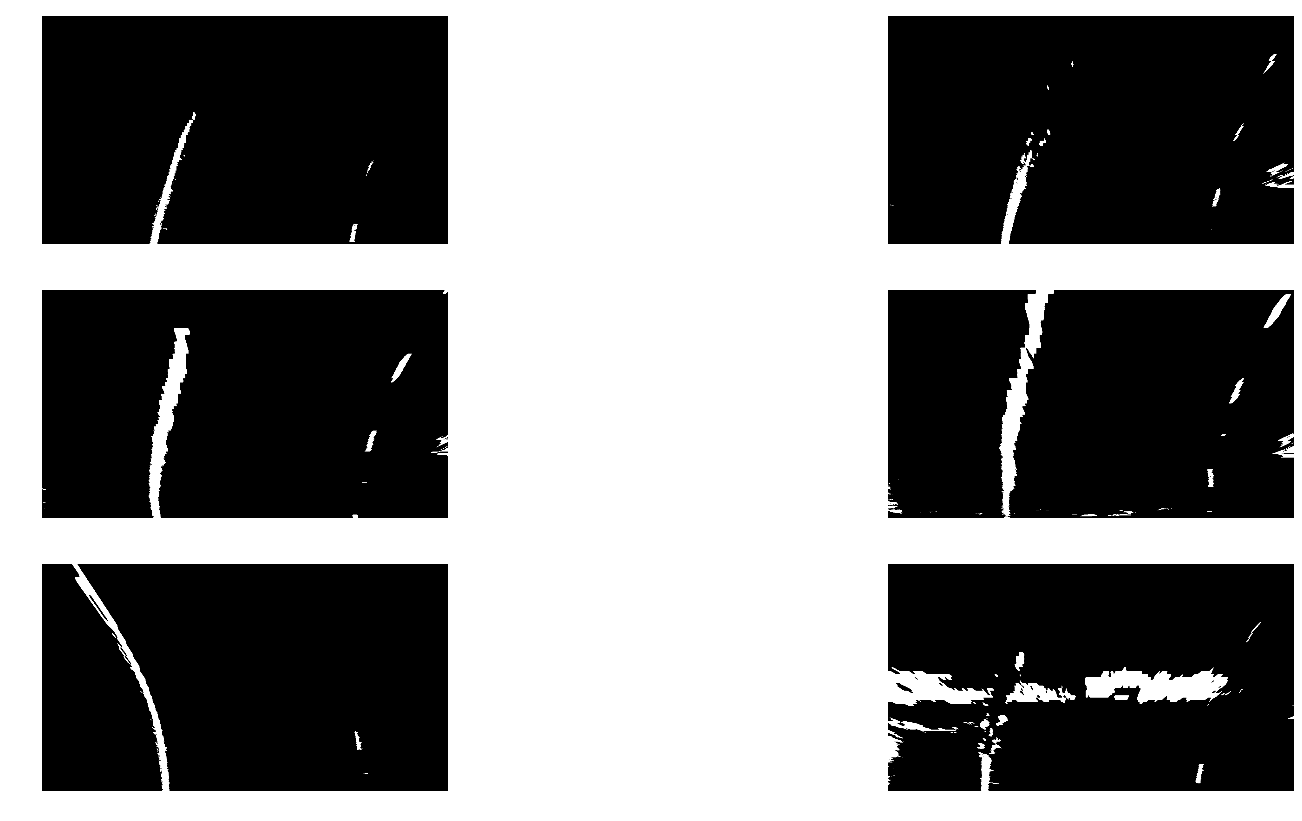

In [18]:
plot_imgArr(bw_imgs_x, n=3, gray=True)

plot_imgArr(bw_imgs_x, n=3, gray=True)


Having identified the lane lines, has the radius of curvature of the road been estimated?
And the position of the vehicle with respect to center in the lane?

### Pipeline (video)

Pass the transformation function to moviepy to get the final video.

In [13]:
clip = VideoFileClip("./project_video.mp4")
clip = clip.fl_image(birds_eye_transform)
clip.write_videofile("./out_video.mp4", audio=False)


MoviePy: building video file ./out_video.mp4
----------------------------------------

Writing video into ./out_video.mp4


/opt/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
100%|██████████| 1210/1210 [02:11<00:00,  9.22it/s]


Done writing video in ./out_video.mp4 !
Your video is ready !


## Discussion